# 引言

### 研究目的

本研究内容参考海通证券研究报告《选股因子系列研究(十七)——选股因子的正交》内容，具体研报可参考【研报分享】海通证券：选股因子的正交https://www.joinquant.com/view/community/detail/e886bc15260a6c4a5444469387c1a731?type=1

近年来，随着投资者对于因子选股体系研究的深入，选股因子值的处理也在逐渐细化，本文将主要对于选股因子的正交进行分析讨论。之所以讨论因子的正交是因为在传统的多因子模型中，选取的因子之间往往存在着相关性，而这种相关性并不稳定，且相关性的存在会复杂因子权重的分配。
对于等权分配因子权重的多因子模型，由于因子之间相关性的存在，模型可能实际上对于某一因子有更高的暴露（例如，市值因子）。 对于权重优化的模型，相关性的影响可能会更大。因此，本文考虑在构建因子的时候对于相关性进行剔除从而达到更为可控的因子暴露。


### 研究框架


研报中主要分为三部分。第一部分对于因子正交的必要性以及正交过程中的相关处理方式进行了说明。 第二部分回测对比了正交多因子模型与原始多因子模型的历史表现。第三部分对于正交顺序的确定进行了讨论。

本研究主要参考第一部分的处理方法，对第二部分内容进行了实证，按照这个思路，展开研究，下面是研究的内容分布：

1）因子数据获取：
 - 设置股票池，获取指定时间范围的月度因子数据，按照研报思路，我们直接获取了聚宽因子库中的因子数据，并加入行业因子，按日期将因子值存入字典，记录保存了原始因子值，方便进行计算构造正交因子。

2）因子数据处理：
  - 将计算出来的因子值按日期遍历获取，根据需要进行数据处理
  - 在T期因子值中加入T+1期收益值，方便因子分析统计

3）因子统计分析：
  - 针对每期截面进行因子IC统计
  - 汇总为时间序列上的IC数据，进行展示

4）分组回测分析：
  - 根据所选的因子，在每个调仓日进行股票排序，分层进行收益净值观察
  - 根据所选因子，在每个调仓日进行股票排序，进行多头组合收益分析
  
###  参数设置

1）时间范围：
- 2014.6 ～ 2019.6

2）研究指数：
- 中证500

3）股票池：
- 中证500指数成分股
- 剔除 ST、停牌、涨跌停、上市不满 6 个月
- 月初调仓


4）费用设置：
- 暂无交易成本设置


### 研究内容及结论

本文参考研报中关于选股因子正交的讨论，通过使用正交选股因子来得到更加可控的因子暴露，我们采取研报中给出的参考顺序进行了正交化处理，通过实际组合的构建以及初步回测， 相比于原始因子收益及夏普都有所提升。 在三因子与八因子两种模型中，对因子IC均有提升，在多头组合中也得到了了印证。

In [1]:
#导入需要的库、定义需要用到的工具函数
#工具函数
import time
from datetime import datetime, timedelta
from jqdata import *
import numpy as np
import pandas as pd
import math
from statsmodels import regression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression as LR
from jqfactor import *

import warnings  
warnings.filterwarnings('ignore') 
plt.style.use('ggplot')

#输入起止日期，返回所有自然日日期
def get_date_list(begin_date, end_date):
    dates = []
    dt = datetime.strptime(begin_date,"%Y-%m-%d")
    date = begin_date[:]
    while date <= end_date:
        dates.append(date)
        dt += timedelta(days=1)
        date = dt.strftime("%Y-%m-%d")
    return dates

#获取日期列表
def get_tradeday_list(start,end,frequency=None,count=None):
    if count != None:
        df = get_price('000001.XSHG',end_date=end,count=count)
    else:
        df = get_price('000001.XSHG',start_date=start,end_date=end)
    if frequency == None or frequency =='day':
        return df.index
    else:
        df['year-month'] = [str(i)[0:7] for i in df.index]
        if frequency == 'month':
            return df.drop_duplicates('year-month').index
        elif frequency == 'quarter':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='04') | (df['month']=='07') | (df['month']=='10') ]
            return df.drop_duplicates('year-month').index
        elif frequency =='halfyear':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='06')]
            return df.drop_duplicates('year-month').index 

#输入开始日期和结束日期，返回每周第一个交易日
def get_weekday(s_date,d_date):
    df = get_price('000001.XSHG',start_date=s_date,end_date=d_date)
    dt_list = []
    for d1,d2 in zip(df.index[:-1],df.index[1:]):
        d_1 = datetime.datetime(int(str(d1)[:4]),int(str(d1)[5:7]),int(str(d1)[8:10]))
        d_2 = datetime.datetime(int(str(d2)[:4]),int(str(d2)[5:7]),int(str(d2)[8:10]))
        weekday1 = d_1.strftime("%w")
        weekday2 = d_2.strftime("%w")
        interday = (d_2 - d_1).days
        if (int(weekday1) >= int(weekday2)) or interday>7:
            dt_list.append(str(d2)[:10])
    return dt_list        

def ret_se(start_date='2018-6-1',end_date='2018-7-1',stock_pool=None,weight=0):
    pool = stock_pool
    if len(pool) != 0:
        #得到股票的历史价格数据
        df = get_price(list(pool),start_date=start_date,end_date=end_date,fields=['close']).close
        df = df.dropna(axis=1)
        #获取列表中的股票流通市值对数值
        df_mkt = get_fundamentals(query(valuation.code,valuation.circulating_market_cap).filter(valuation.code.in_(df.columns)))
        df_mkt.index = df_mkt['code'].values
        fact_se =pd.Series(df_mkt['circulating_market_cap'].values,index = df_mkt['code'].values)
        fact_se = np.log(fact_se)
    else:
        df = get_price('000001.XSHG',start_date=start_date,end_date=end_date,fields=['close'])
        df['v'] = [1]*len(df)
        del df['close']
    #相当于昨天的百分比变化
    pct = df.pct_change()+1
    pct.iloc[0,:] = 1
    if weight == 0:
        #等权重平均收益结果
        se = pct.cumsum(axis=1).iloc[:,-1]/pct.shape[1]
        return se
    else:
        #按权重的方式计算
        se = (pct*fact_se).cumsum(axis=1).iloc[:,-1]/sum(fact_se)
        return se
    
#获取所有分组pct
def get_all_pct(pool_dict,trade_list,groups=5):
    num = 1
    for s,e in zip(trade_list[:-1],trade_list[1:]):
        stock_list = pool_dict[s]
        stock_num = len(stock_list)//groups
        if num == 0:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df1 = pd.concat(pct_se_list,axis=1)
            pct_df1.columns = range(groups)
            pct_df = pd.concat([pct_df,pct_df1],axis=0)
        else:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df = pd.concat(pct_se_list,axis=1)    
            pct_df.columns = range(groups)
            num = 0
    return pct_df

def tradedays_before(date,count):#获取指定交易日往前推count天交易日
    date = get_price('000001.XSHG',end_date=date,count=count+1).index[0]
    return date

def ShiftTradingDay(date,shift):
    # 获取所有的交易日，返回一个包含所有交易日的 list,元素值为 datetime.date 类型.
    tradingday = get_all_trade_days()
    # 得到date之后shift天那一天在列表中的行标号 返回一个数
    date = datetime.date(int(str(date)[:4]),int(str(date)[5:7]),int(str(date)[8:10]))
    shiftday_index = list(tradingday).index(date)+shift
    # 根据行号返回该日日期 为datetime.date类型
    return tradingday[shiftday_index] 

#进行新股、St股过滤，返回筛选后的股票
def filter_stock(stockList,date,days=21*3,skip_paused=1,limit=0):#日频策略加入开盘涨停过滤
    
    #去除上市距beginDate不足3个月的股票
    def delect_stop(stocks,beginDate,n=days):
        stockList=[]
        beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
        for stock in stocks:
            start_date=get_security_info(stock).start_date
            if start_date<(beginDate-datetime.timedelta(days=n)).date():
                stockList.append(stock)
        return stockList
    
    #剔除ST股
    st_data=get_extras('is_st',stockList, count = 1,end_date=date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]

    #剔除当天停牌股
    if skip_paused == 1:
        paused_df = get_price(stockList,end_date=date,count=1,fields=['paused'])['paused'].T
        paused_df.columns = ['paused']
        paused_df = paused_df[paused_df['paused']==0]
        stockList = paused_df.index
    
    #新股及退市股票
    stockList=delect_stop(stockList,date)
    
    #剔除开盘涨停股票
    if limit == 1:
        #如果需要收盘涨跌停可以改字段即可
        df = get_price(stockList,end_date=date,fields=['open','high_limit','low_limit'],count=1).iloc[:,0,:]
        df['h_limit']=(df['open']==df['high_limit'])
        df['l_limit']=(df['open']==df['low_limit'])
        stockList = [df.index[i] for i in range(len(df)) if not (df.h_limit[i] or df.l_limit[i])] #过滤涨跌停股票
    return stockList


###  因子数据获取

In [2]:
#设置股票池（指数成分股）
index = '000905.XSHG' #设置股票池，和对比基准，这里是中证500

#设置统计起止日期
date_start = '2014-05-01'
date_end   = '2019-07-1'

#获取统计期内交易日列表、用于计算因子数据
date_list = get_tradeday_list(start=date_start,end=date_end,frequency='month',count=None)#获取回测日期间的所有交易日
date_list

DatetimeIndex(['2014-05-05', '2014-06-03', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-08', '2014-11-03', '2014-12-01',
               '2015-01-05', '2015-02-02', '2015-03-02', '2015-04-01',
               '2015-05-04', '2015-06-01', '2015-07-01', '2015-08-03',
               '2015-09-01', '2015-10-08', '2015-11-02', '2015-12-01',
               '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-03', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-10', '2016-11-01', '2016-12-01',
               '2017-01-03', '2017-02-03', '2017-03-01', '2017-04-05',
               '2017-05-02', '2017-06-01', '2017-07-03', '2017-08-01',
               '2017-09-01', '2017-10-09', '2017-11-01', '2017-12-01',
               '2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02',
               '2018-05-02', '2018-06-01', '2018-07-02', '2018-08-01',
               '2018-09-03', '2018-10-08', '2018-11-01', '2018-12-03',
      

根据研报中提到的因子，我们直接通过聚宽因子库获取，后面会提到行业因子数据手动计算加入
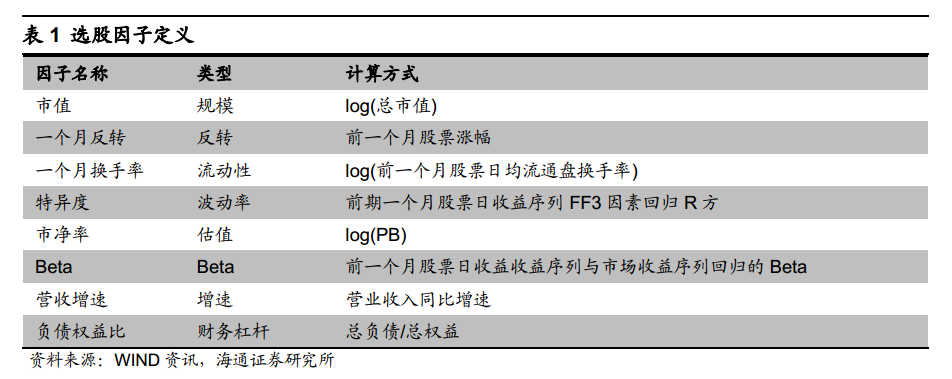

In [ ]:
#查询个股所在行业函数代码（申万一级） ,为中性化函数的子函数    
def get_industry_code_from_security(security,date=None):
    industry_index=get_industries(name='sw_l1').index
    for i in range(0,len(industry_index)):
        try:
            index = get_industry_stocks(industry_index[i],date=date).index(security)
            return industry_index[i]
        except:
            continue
    return u'未找到' 

#为股票池添加行业标记,return df格式 ,为中性化函数的子函数   
def get_industry_exposure(stock_list,date=None):
    df = pd.DataFrame(index=get_industries(name='sw_l1').index, columns=stock_list)
    for stock in stock_list:
        try:
            df[stock][get_industry_code_from_security(stock,date)] = 1
        except:
            print('报错')
            continue
    return df.fillna(0)#将NaN赋为0

In [4]:
#计算并保存因子值数据
#因子获取 市值因子、反转因子、换手率因子
def get_3_factor(stocks_list,date1='2019-06-01',date2='2019-07-01'):
    date2 = str(date2)[:10]
    date1 = str(date1)[:10]
    df = get_fundamentals(query(valuation.code,valuation.market_cap).filter(valuation.code.in_(stocks_list)),date=date2)
    df.index = df['code'].values
    del df['code']
    df = log(df)
    q = query(valuation.turnover_ratio).filter(valuation.code.in_(stocks_list))
    df3 = get_fundamentals_continuously(q, end_date=date2, count=30)['turnover_ratio']
    se_tur = log(df3[df3.index>=date1].mean())

    df1 = get_price(stocks_list,start_date=date1,end_date=date2,fields=['close'])['close']
    se_pct = df1.iloc[-1,:]/df1.iloc[0,:]-1

    df['tur'] = se_tur
    df['pct'] = se_pct
    return df

#计算并保存因子值数据
#八个风格因子
def get_8_factor(stocks_list,date='2019-06-01'):
    factors = ['size','momentum','liquidity','residual_volatility','book_to_price_ratio','beta','earnings_yield','leverage']
    #取值函数
    f_dict = get_factor_values(stocks_list , factors=factors,end_date=date,count=1)
    df = pd.concat([f_dict[factor] for factor in factors],axis=0)
    df.index = factors
    return df.T

stocks_list = ['000001.XSHE','600000.XSHG']
get_8_factor(stocks_list,date=date_list[0])

,size,momentum,liquidity,residual_volatility,book_to_price_ratio,beta,earnings_yield,leverage
code,,,,,,,,
000001.XSHE,0.614343,-0.315892,1.428474,-0.347846,1.168728,0.455703,2.851955,0.220709
600000.XSHG,0.839260,0.184742,1.572740,-0.349360,1.359600,0.180290,2.851955,0.011776


In [5]:
#循环日期列表，进行因子值记录，按字典的方式存储
#进行因子值计算
factor_3_dict = {}
factor_8_dict= {}
#循环时间列表获取原始因子数据组成dict
for date1,date2 in zip(date_list[:-1],date_list[1:]):
    end_date=str(date2)[:10]
    print('正在计算 {} 因子数据......'.format(end_date))
    stocks_list = get_index_stocks(index,date=end_date)#获取指定日期成分股列表
    stocks_list = filter_stock(stocks_list,end_date,days=183,limit=1)#进行股票筛选
    stocks_list = filter_stock(stocks_list,str(date1)[:10],days=183,limit=1)#进行股票筛选
    factor_3_dict[end_date] = get_3_factor(stocks_list,date1=date1,date2=end_date)
    factor_8_dict[end_date] = get_8_factor(stocks_list,date=end_date)

正在计算 2014-06-03 因子数据......
正在计算 2014-07-01 因子数据......
正在计算 2014-08-01 因子数据......
正在计算 2014-09-01 因子数据......
正在计算 2014-10-08 因子数据......
正在计算 2014-11-03 因子数据......
正在计算 2014-12-01 因子数据......
正在计算 2015-01-05 因子数据......
正在计算 2015-02-02 因子数据......
正在计算 2015-03-02 因子数据......
正在计算 2015-04-01 因子数据......
正在计算 2015-05-04 因子数据......
正在计算 2015-06-01 因子数据......
正在计算 2015-07-01 因子数据......
正在计算 2015-08-03 因子数据......
正在计算 2015-09-01 因子数据......
正在计算 2015-10-08 因子数据......
正在计算 2015-11-02 因子数据......
正在计算 2015-12-01 因子数据......
正在计算 2016-01-04 因子数据......
正在计算 2016-02-01 因子数据......
正在计算 2016-03-01 因子数据......
正在计算 2016-04-01 因子数据......
正在计算 2016-05-03 因子数据......
正在计算 2016-06-01 因子数据......
正在计算 2016-07-01 因子数据......
正在计算 2016-08-01 因子数据......
正在计算 2016-09-01 因子数据......
正在计算 2016-10-10 因子数据......
正在计算 2016-11-01 因子数据......
正在计算 2016-12-01 因子数据......
正在计算 2017-01-03 因子数据......
正在计算 2017-02-03 因子数据......
正在计算 2017-03-01 因子数据......
正在计算 2017-04-05 因子数据......
正在计算 2017-05-02 因子数据......
正在计算 2017-06-01 因子数据......
正

### 因子数据处理

- 进行因子值数据处理、如有必要可进行去极值、标准化、中性化
- 加入收益数据：将T期因子值中加入T~T+1的收益数据进行记录

参考研报中给出的中性化顺序、
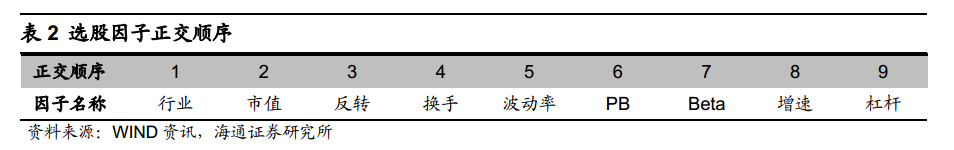

In [6]:
#数据清洗、包括去极值、标准化、中性化等,并加入y值
import time  
t1 = time.time()
factor_3_y_dict = {}
factor_8_y_dict = {}
for date_1,date_2 in zip(date_list[1:-1],date_list[2:]):
    d1 = ShiftTradingDay(date_1,1) #往后推一天
    d2 = ShiftTradingDay(date_2,1)
    print('开始整理 {} 数据...'.format(str(date_1)[:10]))
    factor_3_df = factor_3_dict[str(date_1)[:10]] #根据字典存储的日期格式不同进行不同设置
    factor_8_df = factor_8_dict[str(date_1)[:10]] #根据字典存储的日期格式不同进行不同设置
    pool = list(factor_3_df.index)
    
    #计算指数涨跌幅
    df_1 = get_price(index,end_date=d1,fields=['open'],count = 1)['open']
    df_2 = get_price(index,end_date=d2,fields=['open'],count = 1)['open']
    index_pct = df_2.values[0]/df_1.values[0] - 1#具体数值
    
    #计算各股票涨跌幅
    df_1 = get_price(pool,end_date=d1,fields=['open'],count = 1)['open']
    df_2 = get_price(pool,end_date=d2,fields=['open'],count = 1)['open']
    df_3 = pd.concat([df_1,df_2],axis=0).T #进行合并
    stock_pct = df_3.iloc[:,1]/df_3.iloc[:,0] - 1 #计算pct，series
    
    #对数据进行处理、标准化、去极值、中性化
    factor_3_df = winsorize_med(factor_3_df, scale=3, inclusive=True, inf2nan=True, axis=0) #中位数去极值处理
    factor_8_df = winsorize_med(factor_8_df, scale=3, inclusive=True, inf2nan=True, axis=0) #中位数去极值处理
    factor_3_df = standardlize(factor_3_df, inf2nan=True, axis=0) #对每列做标准化处理
    factor_8_df = standardlize(factor_8_df, inf2nan=True, axis=0) #对每列做标准化处理

    #factor_df['pct_alpha'] =  stock_pct-index_pct
    factor_3_df['y'] =  stock_pct
    factor_8_df['y'] =  stock_pct
    
    #进行正交因子记录
    factor_list = ['size','momentum','liquidity','residual_volatility','book_to_price_ratio','beta','earnings_yield','leverage']
    
    factor_new_list = []
    #先对市值因子进行行业中性化
    for factor in ['market_cap','tur','pct']:
        if factor == 'market_cap':
            factor_3_df[factor+'_'] = neutralize(factor_3_df[factor], how=['sw_l1'], date=str(date_1)[:10], axis=0,fillna='sw_l1')#中性化
            factor_new_list.append(factor+'_')
        else:
            #对factor正交
            X = factor_3_df[factor_new_list]
            y = factor_3_df[factor]
            reg = LR().fit(X,y)
            factor_3_df[factor+'_'] = y - reg.predict(X)
            factor_new_list.append(factor+'_')

    factor_3_y_dict[str(date_1)[:10]] = factor_3_df
    
    factor_new_list = []
    #先对市值因子进行行业中性化
    for factor in factor_list:
        if factor == 'size':
            factor_8_df['size'+'_'] = neutralize(factor_8_df['size'], how=['sw_l1'], date=str(date_1)[:10], axis=0,fillna='sw_l1')#中性化
            factor_new_list.append('size_')
        else:
            #对factor正交
            X = factor_8_df[factor_new_list]
            y = factor_8_df[factor]
            reg = LR().fit(X,y)
            factor_8_df[factor+'_'] = y - reg.predict(X)
            factor_new_list.append(factor+'_')

    factor_8_y_dict[str(date_1)[:10]] = factor_8_df
    
t2 = time.time()
print('计算数据耗时：{0}'.format(t2-t1))
print(factor_3_y_dict[str(date_1)[:10]].shape)

开始整理 2014-06-03 数据...
开始整理 2014-07-01 数据...
开始整理 2014-08-01 数据...
开始整理 2014-09-01 数据...
开始整理 2014-10-08 数据...
开始整理 2014-11-03 数据...
开始整理 2014-12-01 数据...
开始整理 2015-01-05 数据...
开始整理 2015-02-02 数据...
开始整理 2015-03-02 数据...
开始整理 2015-04-01 数据...
开始整理 2015-05-04 数据...
开始整理 2015-06-01 数据...
开始整理 2015-07-01 数据...
开始整理 2015-08-03 数据...
开始整理 2015-09-01 数据...
开始整理 2015-10-08 数据...
开始整理 2015-11-02 数据...
开始整理 2015-12-01 数据...
开始整理 2016-01-04 数据...
开始整理 2016-02-01 数据...
开始整理 2016-03-01 数据...
开始整理 2016-04-01 数据...
开始整理 2016-05-03 数据...
开始整理 2016-06-01 数据...
开始整理 2016-07-01 数据...
开始整理 2016-08-01 数据...
开始整理 2016-09-01 数据...
开始整理 2016-10-10 数据...
开始整理 2016-11-01 数据...
开始整理 2016-12-01 数据...
开始整理 2017-01-03 数据...
开始整理 2017-02-03 数据...
开始整理 2017-03-01 数据...
开始整理 2017-04-05 数据...
开始整理 2017-05-02 数据...
开始整理 2017-06-01 数据...
开始整理 2017-07-03 数据...
开始整理 2017-08-01 数据...
开始整理 2017-09-01 数据...
开始整理 2017-10-09 数据...
开始整理 2017-11-01 数据...
开始整理 2017-12-01 数据...
开始整理 2018-01-02 数据...
开始整理 2018-02-01 数据...
开始整理 2018-

In [8]:
factor_3_y_dict[str(date_1)[:10]].head(3)

,market_cap,tur,pct,y,market_cap_,tur_,pct_
000006.XSHE,-1.183287,-0.773171,-0.051458,0.050943,-1.270898,-0.972542,0.125768
000008.XSHE,-0.447743,-0.513199,-0.511732,0.026385,-0.292191,-0.559036,-0.481746
000009.XSHE,-0.155374,0.102236,-0.413471,0.031690,0.104927,0.118697,-0.426872


### 因子计算与分析
- IC统计
- 根据IC值计算等权多因子组合打分
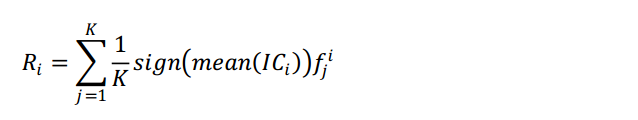

### 2.1等权多因子模型
### 2.2最大化收益预期多因子模型

接下来的研究中，我们分别对于三因子与八个风格因子做如下分类进行研究

|（因子模型）\（因子处理） | 原始因子 | 正交因子 |
| ------ | ------ | ------ |
| 等权多因子模型 | factor_a | factor_b |
| 最大化收益预期 |  factor_c | factor_d |

In [9]:
#3因子
#记录IC值
#统计记录IC值
ic_df = pd.DataFrame()
for d in date_list[1:-1]:
    d = str(d)[:10]
    ic_df[d] = (factor_3_y_dict[d].corr()).loc[:,'y']

#记录ic的均值，这里取5期均值作为型号函数参数
ic_mean = ic_df.rolling(5,axis=1).mean()
ic_mean.iloc[:,:4] = ic_df.iloc[:,:4]
sign_df = sign(ic_mean)

#等权多因子模型
factor_3_list = ['market_cap','tur','pct']
factor_3_list_ = ['market_cap_','tur_','pct_']

for d1,d2 in zip(date_list[1:-2],date_list[2:-1]):
    d1,d2 = str(d1)[:10],str(d2)[:10]
    factor_df_ = factor_3_y_dict[d1]
    factor_df  = factor_3_y_dict[d2]
    #等权
    factor_df['factor_a'] = np.dot(factor_df[factor_3_list],sign_df[d1][factor_3_list])
    factor_df['factor_b'] = np.dot(factor_df[factor_3_list_],sign_df[d1][factor_3_list_])

    #预测值
    X_ = factor_df_[factor_3_list+['y']]
    X_ = X_.dropna()
    reg = LR(fit_intercept=False).fit(X_[factor_3_list],X_['y'])
    X = factor_df[factor_3_list]
    factor_df['factor_c'] =  reg.predict(X)

    #预测值
    X_ = factor_df_[factor_3_list_+['y']]
    X_ = X_.dropna()
    reg = LR(fit_intercept=False).fit(X_[factor_3_list_],X_['y'])
    X = factor_df[factor_3_list_]
    factor_df['factor_d'] =  reg.predict(X)
    factor_3_y_dict[d2] = factor_df

In [10]:
#8因子
#记录IC值
#统计记录IC值
ic_df = pd.DataFrame()
for d in date_list[1:-1]:
    d = str(d)[:10]
    ic_df[d] = (factor_8_y_dict[d].corr()).loc[:,'y']

#记录ic的均值，这里取5期均值作为型号函数参数
ic_mean = ic_df.rolling(5,axis=1).mean()
ic_mean.iloc[:,:4] = ic_df.iloc[:,:4]
sign_df = sign(ic_mean)

#等权多因子模型
factor_8_list = ['size','momentum','liquidity','residual_volatility','book_to_price_ratio','beta','earnings_yield','leverage']
factor_8_list_ = [factor+'_' for factor in factor_8_list]

for d1,d2 in zip(date_list[1:-2],date_list[2:-1]):
    d1,d2 = str(d1)[:10],str(d2)[:10]
    factor_df_ = factor_8_y_dict[d1]
    factor_df  = factor_8_y_dict[d2]
    #等权
    factor_df['factor_a'] = np.dot(factor_df[factor_8_list],sign_df[d1][factor_8_list])
    factor_df['factor_b'] = np.dot(factor_df[factor_8_list_],sign_df[d1][factor_8_list_])

    #预测值
    X_ = factor_df_[factor_8_list+['y']]
    X_ = X_.dropna()
    reg = LR(fit_intercept=False).fit(X_[factor_8_list],X_['y'])
    X = factor_df[factor_8_list]
    factor_df['factor_c'] =  reg.predict(X)

    #预测值
    X_ = factor_df_[factor_8_list_+['y']]
    X_ = X_.dropna()
    reg = LR(fit_intercept=False).fit(X_[factor_8_list_],X_['y'])
    X = factor_df[factor_8_list_]
    factor_df['factor_d'] =  reg.predict(X)
    factor_8_y_dict[d2] = factor_df

在下面的内容中，我们将对所有因子IC值进行统计记录，并记录各因子值IC均值、IC标准差、IC最小值、IC最大值、负IC占比

并将IC值与累计IC进行统计展示

========================因子：factor_a IC统计信息如下======================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比     IC_IR
2014 -0.017538  0.124705 -0.246621  0.089271  0.5000 -0.140638
2015  0.071137  0.173595 -0.391035  0.312932  0.1667  0.409786
2016  0.053121  0.137648 -0.162805  0.278617  0.3333  0.385920
2017  0.048078  0.125649 -0.177519  0.253278  0.2500  0.382635
2018  0.030171  0.163429 -0.273895  0.236523  0.3333  0.184612
2019 -0.024473  0.164221 -0.273033  0.183985  0.5000 -0.149026
所有年份  0.036300  0.147268 -0.391035  0.312932  0.3167  0.246489


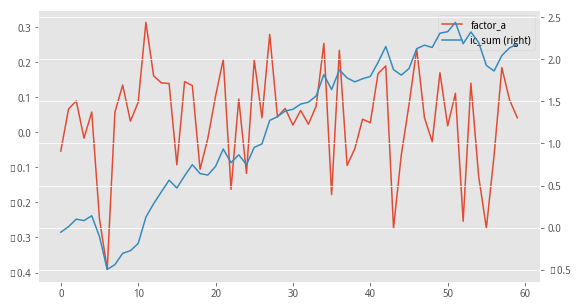

========================因子：factor_b IC统计信息如下======================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比     IC_IR
2014  0.027131  0.054115 -0.042642  0.098155  0.3333  0.501354
2015  0.070938  0.159593 -0.347438  0.312901  0.1667  0.444492
2016  0.046544  0.140073 -0.175027  0.212870  0.2500  0.332284
2017  0.031378  0.134259 -0.220017  0.243917  0.2500  0.233715
2018  0.052601  0.121627 -0.206282  0.234303  0.2500  0.432474
2019 -0.034569  0.164682 -0.287688  0.153701  0.5000 -0.209914
所有年份  0.039548  0.133809 -0.347438  0.312901  0.2667  0.295558


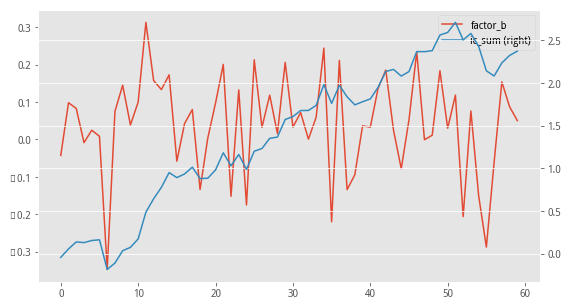

========================因子：factor_c IC统计信息如下======================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比     IC_IR
2014  0.040188  0.119786 -0.176964  0.184186  0.1667  0.335499
2015  0.055830  0.190043 -0.431224  0.262616  0.2500  0.293779
2016  0.032703  0.129978 -0.172952  0.221127  0.3333  0.251604
2017 -0.007106  0.168578 -0.319850  0.251916  0.5833 -0.042154
2018 -0.047817  0.145440 -0.249650  0.205273  0.6667 -0.328773
2019 -0.018378  0.216746 -0.341112  0.168363  0.3333 -0.084790
所有年份  0.008903  0.160522 -0.431224  0.262616  0.4167  0.055464


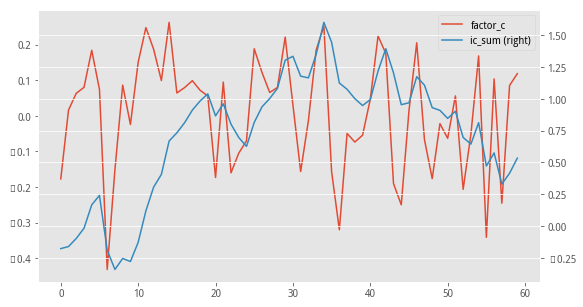

========================因子：factor_d IC统计信息如下======================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比     IC_IR
2014  0.072537  0.054451 -0.000394  0.156377  0.1667  1.332152
2015  0.054744  0.196954 -0.449488  0.289851  0.2500  0.277956
2016  0.023425  0.139099 -0.254416  0.206825  0.3333  0.168408
2017 -0.003378  0.164517 -0.332777  0.240672  0.5000 -0.020531
2018 -0.051295  0.141295 -0.252695  0.199002  0.6667 -0.363031
2019 -0.028938  0.217763 -0.349407  0.161143  0.3333 -0.132886
所有年份  0.009059  0.160229 -0.449488  0.289851  0.4000  0.056541


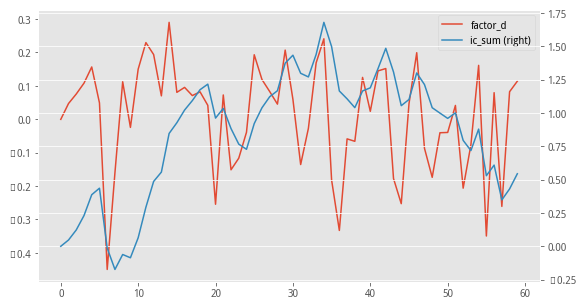

In [13]:
#统计记录IC值
ic_df = pd.DataFrame()
for d in date_list[2:-1]:
    d = str(d)[:10]
    ic_df[d] = (factor_3_y_dict[d].corr()).loc[:,'y']

#所有因子信息统计如下
factor_alg = ['factor_a','factor_b','factor_c','factor_d']


for factor in factor_alg:
    ic_ = ic_df.T
    ic_df_temp = ic_df.T[factor]
    tab_ic = pd.DataFrame()
    
    for year in range(2014,2020):
        #表格统计
        ic_temp = ic_[(ic_.index>(str(year)+'-01-01')) & (ic_.index<(str(year+1)+'-01-01'))]
        tab_ic[str(year)] = [ic_temp[factor].mean(),ic_temp[factor].std(),ic_temp[factor].min(),ic_temp[factor].max(),round(sum(ic_temp[factor]<0)/len(ic_temp),4)]

    tab_ic['所有年份'] = [ic_[factor].mean(),ic_[factor].std(),ic_[factor].min(),ic_[factor].max(),round(sum(ic_[factor]<0)/len(ic_),4)]
    tab_ic.index=['IC均值','IC标准差',"IC最小值","IC最大值","负IC占比"]
    print('========================因子：{} IC统计信息如下======================'.format(factor))
    tab_ic = tab_ic.T
    if factor != 'y':
        tab_ic['IC_IR'] = tab_ic['IC均值']/tab_ic['IC标准差']
    print(tab_ic)
    
    #进行IC值展示
    ic_df_temp1 = ic_df.T[[factor]]
    ic_df_temp1['ic_sum'] = ic_df_temp1[factor].cumsum()
    ic_df_temp1.plot(use_index=False,y=[factor,'ic_sum'],secondary_y=['ic_sum'],figsize=(9,5))
    plt.show()

以上是针对三因子进行因子正交的结果统计，通过因子IC计算，获得如下信息：
- 将原始因子进行正交，且在等权分组下IC值最高，也就是factor_b表现最好
- 两种因子模型中，正交因子IC值均大于原始因子IC
- 等权多因子模型因子IC远超最大化收益预期因子IC

========================因子：factor_a IC统计信息如下======================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比     IC_IR
2014  0.050919  0.197914 -0.154034  0.274019  0.5000  0.257277
2015 -0.037982  0.135574 -0.236333  0.163321  0.5833 -0.280160
2016  0.075084  0.150006 -0.169020  0.310844  0.2500  0.500541
2017  0.054524  0.113728 -0.187793  0.239862  0.2500  0.479421
2018  0.010294  0.189112 -0.338846  0.222067  0.4167  0.054433
2019 -0.063888  0.115252 -0.206008  0.080114  0.6667 -0.554333
所有年份  0.019087  0.153365 -0.338846  0.310844  0.4167  0.124454


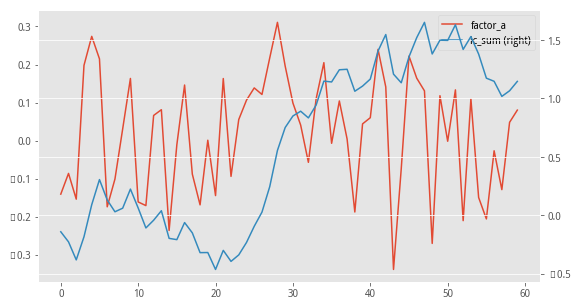

========================因子：factor_b IC统计信息如下======================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比     IC_IR
2014  0.117090  0.150642 -0.042009  0.293220  0.3333  0.777278
2015 -0.029352  0.133764 -0.290880  0.216595  0.5000 -0.219428
2016  0.061530  0.109532 -0.116220  0.296168  0.2500  0.561755
2017  0.025427  0.132253 -0.174656  0.273113  0.4167  0.192261
2018  0.018354  0.129832 -0.198739  0.175450  0.4167  0.141368
2019 -0.022994  0.096336 -0.169612  0.074829  0.5000 -0.238680
所有年份  0.024602  0.129089 -0.290880  0.296168  0.4000  0.190580


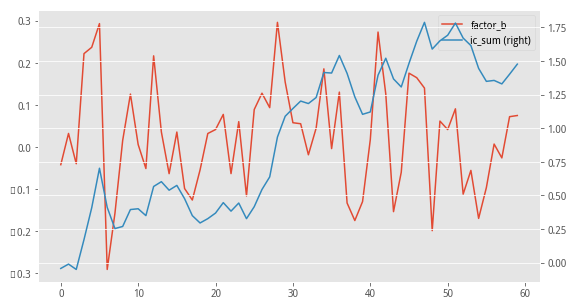

========================因子：factor_c IC统计信息如下======================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比     IC_IR
2014  0.133941  0.237370 -0.071692  0.497230  0.5000  0.564270
2015 -0.042432  0.165020 -0.433392  0.206798  0.5000 -0.257134
2016  0.072190  0.110240 -0.075665  0.225292  0.3333  0.654838
2017  0.072251  0.124198 -0.096468  0.269312  0.3333  0.581744
2018 -0.012845  0.165180 -0.321072  0.240996  0.5833 -0.077767
2019 -0.021236  0.229861 -0.373027  0.199288  0.3333 -0.092386
所有年份  0.029103  0.167597 -0.433392  0.497230  0.4333  0.173650


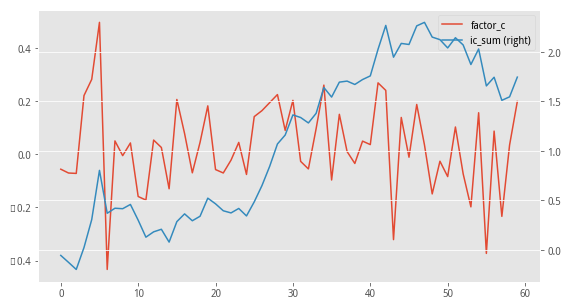

========================因子：factor_d IC统计信息如下======================
          IC均值     IC标准差     IC最小值     IC最大值   负IC占比     IC_IR
2014  0.146349  0.214446 -0.055401  0.477480  0.5000  0.682451
2015 -0.036516  0.158761 -0.416434  0.210858  0.4167 -0.230003
2016  0.070505  0.110067 -0.092411  0.234537  0.3333  0.640558
2017  0.075719  0.123733 -0.101036  0.247039  0.4167  0.611954
2018 -0.013557  0.161304 -0.315654  0.243071  0.5833 -0.084044
2019 -0.021096  0.241235 -0.384796  0.192966  0.3333 -0.087448
所有年份  0.031756  0.164851 -0.416434  0.477480  0.4333  0.192632


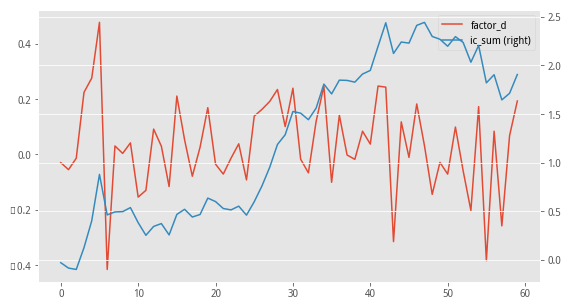

In [12]:
#统计记录IC值
ic_df = pd.DataFrame()
for d in date_list[2:-1]:
    d = str(d)[:10]
    ic_df[d] = (factor_8_y_dict[d].corr()).loc[:,'y']

#所有因子信息统计如下
factor_alg = ['factor_a','factor_b','factor_c','factor_d']
for factor in factor_alg:
    ic_ = ic_df.T
    ic_df_temp = ic_df.T[factor]
    tab_ic = pd.DataFrame()
    
    for year in range(2014,2020):
        #表格统计
        ic_temp = ic_[(ic_.index>(str(year)+'-01-01')) & (ic_.index<(str(year+1)+'-01-01'))]
        tab_ic[str(year)] = [ic_temp[factor].mean(),ic_temp[factor].std(),ic_temp[factor].min(),ic_temp[factor].max(),round(sum(ic_temp[factor]<0)/len(ic_temp),4)]

    tab_ic['所有年份'] = [ic_[factor].mean(),ic_[factor].std(),ic_[factor].min(),ic_[factor].max(),round(sum(ic_[factor]<0)/len(ic_),4)]
    tab_ic.index=['IC均值','IC标准差',"IC最小值","IC最大值","负IC占比"]
    print('========================因子：{} IC统计信息如下======================'.format(factor))
    tab_ic = tab_ic.T
    if factor != 'y':
        tab_ic['IC_IR'] = tab_ic['IC均值']/tab_ic['IC标准差']
    print(tab_ic)
    
    #进行IC值展示
    ic_df_temp1 = ic_df.T[[factor]]
    ic_df_temp1['ic_sum'] = ic_df_temp1[factor].cumsum()
    ic_df_temp1.plot(use_index=False,y=[factor,'ic_sum'],secondary_y=['ic_sum'],figsize=(9,5))
    plt.show()

以上是针对八个风格因子进行因子正交的结果统计，通过因子IC计算，获得如下信息：
- 最大化收益预期模型下，且进行因子正交的表现最好，五年IC均值为0.0318，也就是factor_d分组
- 和三因子的测试效果一样，两种因子模型中，正交因子IC值均大于原始因子IC值
- 在八个风格因子的测试中，最大化收益预期模型要优于等权多因子模型

### 分组回测
- 多头收益
- 分组收益

接下来，我们将对所有因子值进行分组收益统计，并记录各分组总收益、年化收益、夏普率、最大回撤、每日收益情况

并将分组年化收益进行统计展示

In [29]:
factor_alg = ['factor_a','factor_b','factor_c','factor_d']
factor_3_alg_dict = {}

def get_risk_index(se): #输入每日收益变化，从零算起
    return_se = se.cumprod()-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(250/len(return_se))-1)
    sharpe = (total_an_returns-0.025)/(np.std(se)*np.sqrt(250))
    returns_mean = round(se.mean()-1,6)*100
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    #print('策略运行时间：{} 至 {}'.format(str(return_se.index[0])[:10],str(return_se.index[-1])[:10]))
    total_returns = str(round(total_returns*100,2))+'%'
    total_an_returns = str(round(total_an_returns*100,2))+'%'
    sharpe = str(round(sharpe,2))
    max_drawdown = str(round(max_drawdown*100,2))+'%'
    
    return total_returns,total_an_returns,sharpe,max_drawdown,returns_mean

for factor in factor_alg:
    #获取因子值组成df
    factor_df = pd.DataFrame()
    for d in date_list[2:-1]:
        d = str(d)[:10]
        factor_df[d] = factor_3_y_dict[d].loc[:,factor]
    factor_df =factor_df.T
    rev = 1
    fe= 0.00
    #开始
    hold_num = 50
    pct_adj = 1

    backtest_list = get_tradeday_list(start=factor_df.index[0],end=factor_df.index[-1],count=None)
    return_alpha_df = pd.DataFrame()
    return_index_df = pd.DataFrame()
    return_df = pd.DataFrame()
    trade_record_df = pd.DataFrame()

    #中间变量
    pool_temp_bf = []
    tur = 0
    tur_list = []
    trade = 0
    mark = 0
    year = str(backtest_list[0])[:4]

    for d1,d2 in zip(backtest_list[:-1],backtest_list[1:]):
        d1_ = ShiftTradingDay(d1,1) #往后推一天
        d2_ = ShiftTradingDay(d2,1)
        d1 = str(d1)[:10]
        d2 = str(d2)[:10]

        #调仓日获取最新股票列表
        if d1 in factor_df.index:
            #print('===触发调仓===')
            trade = 1
            #获取头部股票
            #print('{}进行调仓操作'.format(str(d1_)[:10]))
            df_temp = factor_df.loc[d1,:].sort_values(ascending=True) #mo默认从小到大排序
            df_temp = df_temp.dropna()
            if rev == 0:
                pool_temp = df_temp.index[:hold_num]
            else:
                pool_temp = df_temp.index[-hold_num:]

            #trade_record_df[str(d1_)[:10]] = pool_temp
            tur_temp = len([stock for stock in pool_temp if stock not in pool_temp_bf])/len(pool_temp) #换手率
            tur_list.append(tur_temp)
            #print换手率b
            if str(d1)[:4] == year:
                tur += tur_temp
            else:
                #print('{} 年持仓交易换手率为： {}'.format(year,round(tur,2)))
                tur = 0
                year = str(d1)[:4]
            pool_temp_bf = pool_temp

        if pct_adj == 1: #常规的方法
            #计算组合收益
            df1 = get_price(list(pool_temp),end_date=d1_,count=1,fields=['open'])['open'] #index为日期，columns为股票名称
            df1 = df1.dropna(axis=1) #去掉NAN值，删除列
            df2 = get_price(list(df1.columns),end_date=d2_,count=1,fields=['open'])['open']
            ret = (df2.values/df1.values).mean() #计算组合收益均值
            #调仓是减去手续费
            if trade == 1:
                ret = ret*(1-tur_temp*fe)
                trade = 0
            #计算同期指数收益率
            df_index1 = get_price('000905.XSHG',end_date=d1_,count=1,fields=['open'])['open']
            df_index2 = get_price('000905.XSHG',end_date=d2_,count=1,fields=['open'])['open']
            index_ret = df_index2.values[-1]/df_index1.values[-1]

        if pct_adj == 2: #常规的方法
            #计算组合收益
            df1 = get_price(list(pool_temp),end_date=d1,count=1,fields=['close'])['close'] #index为日期，columns为股票名称
            df1 = df1.dropna(axis=1) #去掉NAN值，删除列
            df2 = get_price(list(df1.columns),end_date=d2,count=1,fields=['close'])['close']
            ret = (df2.values/df1.values).mean() #计算组合收益均值
            #调仓是减去手续费
            if trade == 1:
                ret = ret*(1-tur_temp*fe)
                trade = 0
            #计算同期指数收益率
            df_index1 = get_price('000905.XSHG',end_date=d1,count=1,fields=['close'])['close']
            df_index2 = get_price('000905.XSHG',end_date=d2,count=1,fields=['close'])['close']
            index_ret = df_index2.values[-1]/df_index1.values[-1]

        if pct_adj == 3: #设置指定时间点
            #计算组合收益
            df1 = get_price(list(pool_temp),end_date=str(d1_)[:10]+' 14:56:00',frequency='1m',count=1,fields=['close'])['close'] #index为日期，columns为股票名称
            df1 = df1.dropna(axis=1) #去掉NAN值，删除列
            df2 = get_price(list(df1.columns),end_date=str(d2_)[:10]+' 14:50:00',frequency='1m',count=1,fields=['close'])['close']
            ret = (df2.values/df1.values).mean() #计算组合收益均值
            #调仓是减去手续费
            if trade == 1:
                ret = ret*(1-tur_temp*fe)
                trade = 0
            #计算同期指数收益率
            df_index1 = get_price('000905.XSHG',end_date=str(d1_)[:10]+' 14:56:00',count=1,frequency='1m',fields=['close'])['close']
            df_index2 = get_price('000905.XSHG',end_date=str(d2_)[:10]+' 14:50:00',count=1,frequency='1m',fields=['close'])['close']
            index_ret = df_index2.values[-1]/df_index1.values[-1]

        if pct_adj == 4: #有重叠模型
            if mark ==0:#首次
                pool_old = []
                pool_new = pool_temp
                #计算组合日内收益
                df1 = get_price(list(pool_new),end_date=str(d1_)[:10],count=1,fields=['open'])['open'] #index为日期，columns为股票名称
                df1 = df1.dropna(axis=1) #去掉NAN值，删除列
                df2 = get_price(list(df1.columns),end_date=str(d1_)[:10],count=1,fields=['close'])['close']
                ret1 = (df2.values/df1.values).mean() #计算组合收益均值
                #整体收益
                ret = (0.5+ret1/2)
                #调仓是减去手续费
                if trade == 1:
                    ret = ret*(1-0.5*tur_temp*fe)
                    trade = 0
                #计算同期指数收益率
                df_index1 = get_price('000905.XSHG',end_date=str(d1)[:10],count=1,fields=['close'])['close']
                df_index2 = get_price('000905.XSHG',end_date=str(d2)[:10],count=1,fields=['close'])['close']
                index_ret = df_index2.values[-1]/df_index1.values[-1]
                mark = 1
            else:#多次
                pool_old = pool_new
                pool_new = pool_temp
                #计算组合日内收益
                df1 = get_price(list(pool_new)+list(pool_old),end_date=str(d1_)[:10],count=1,fields=['open'])['open'] #index为日期，columns为股票名称
                df1 = df1.dropna(axis=1) #去掉NAN值，删除列
                df2 = get_price(list(df1.columns),end_date=str(d1_)[:10],count=1,fields=['close'])['close']
                ret1 = (df2.values/df1.values).mean() #计算组合收益均值
                #计算组合日间收益
                df1 = get_price(list(pool_old),end_date=str(d1)[:10],count=1,fields=['close'])['close'] #index为日期，columns为股票名称
                df1 = df1.dropna(axis=1) #去掉NAN值，删除列
                df2 = get_price(list(df1.columns),end_date=str(d2)[:10],count=1,fields=['open'])['open']
                ret2 = (df2.values/df1.values).mean() #计算组合收益均值
                #整体收益
                ret = ret1*(0.5+ret2/2)
                #调仓是减去手续费
                if trade == 1:
                    ret = ret*(1-0.5*tur_temp*fe)
                    trade = 0
                #计算同期指数收益率
                df_index1 = get_price('000905.XSHG',end_date=str(d1)[:10],count=1,fields=['close'])['close']
                df_index2 = get_price('000905.XSHG',end_date=str(d2)[:10],count=1,fields=['close'])['close']
                index_ret = df_index2.values[-1]/df_index1.values[-1]

        return_alpha_df[d1] = [ret-index_ret]  #记录超额收益
        return_df[d1] = [ret]  #记录组合收益
        return_index_df[d1] = [index_ret]  #记录基准收益

    return_df = return_df.T
    return_alpha_df = return_alpha_df.T
    return_index_df = return_index_df.T
    return_all_df = pd.concat([return_df,return_alpha_df+1,return_index_df],axis=1)
    return_all_df.columns = ['ret','alpha','index']
    #进行调仓股票记录
    trade_record_df.to_csv('trade_record.csv')

    summary = pd.DataFrame(index=['总收益','年化收益','夏普率','最大回撤','每日收益%'])
    summary['ret'] = get_risk_index(return_all_df['ret'])
    summary['alpha']=get_risk_index(return_all_df['alpha'])
    summary['index']=get_risk_index(return_all_df['index'])
    summary = summary.T

    year_list = list(set([int(i[:4]) for i in return_all_df.index]))
    for year in year_list:
        return_year_df = return_all_df[(return_all_df.index<str(year)+'-12-31') & (return_all_df.index>str(year)+'-01-01')]
        summary[year] = round(return_year_df.cumprod().iloc[-1,:]*100-100,2).values


    print('=====策略运行时间：{} 至 {}====='.format(str(return_all_df.index[0])[:10],str(return_all_df.index[-1])[:10]))
    print('测试因子为{}  调仓均换手率为：{}'.format(factor,round(np.mean(tur_list),3)))
    factor_3_alg_dict[factor] = summary
    print(summary)

=====策略运行时间：2014-07-01 至 2019-05-31=====
测试因子为factor_a  调仓均换手率为：0.644
           总收益    年化收益   夏普率    最大回撤  ...     2018   2019   2014   2015
ret    121.37%  18.01%  0.44  46.08%  ...   -26.35  23.19  34.41  84.41
alpha   88.32%   14.1%  1.31   12.1%  ...    12.24   4.74  -0.64  36.56
index   22.71%   4.36%  0.06  65.85%  ...   -34.75  17.33  35.14  41.29

[3 rows x 11 columns]
=====策略运行时间：2014-07-01 至 2019-05-31=====
测试因子为factor_b  调仓均换手率为：0.654
           总收益    年化收益   夏普率    最大回撤  ...     2018   2019   2014   2015
ret    115.45%  17.34%  0.42  46.09%  ...   -26.86  19.14  36.21  92.93
alpha   83.11%  13.43%  1.27   9.37%  ...    11.51   1.23   0.79  42.68
index   22.71%   4.36%  0.06  65.85%  ...   -34.75  17.33  35.14  41.29

[3 rows x 11 columns]
=====策略运行时间：2014-07-01 至 2019-05-31=====
测试因子为factor_c  调仓均换手率为：0.781
          总收益    年化收益   夏普率    最大回撤  ...     2018   2019   2014   2015
ret    69.69%  11.65%  0.25  53.45%  ...   -36.33  13.69  36.22  80.42
alpha  45.45%   8.12%  0.5

In [30]:
factor_alg = ['factor_a','factor_b','factor_c','factor_d']
factor_8_alg_dict = {}

for factor in factor_alg:
    #获取因子值组成df
    factor_df = pd.DataFrame()
    for d in date_list[2:-1]:
        d = str(d)[:10]
        factor_df[d] = factor_8_y_dict[d].loc[:,factor]
    factor_df =factor_df.T
    rev = 1
    fe= 0.00
    #开始
    hold_num = 50
    pct_adj = 1

    backtest_list = get_tradeday_list(start=factor_df.index[0],end=factor_df.index[-1],count=None)
    return_alpha_df = pd.DataFrame()
    return_index_df = pd.DataFrame()
    return_df = pd.DataFrame()
    trade_record_df = pd.DataFrame()

    #中间变量
    pool_temp_bf = []
    tur = 0
    tur_list = []
    trade = 0
    mark = 0
    year = str(backtest_list[0])[:4]

    for d1,d2 in zip(backtest_list[:-1],backtest_list[1:]):
        d1_ = ShiftTradingDay(d1,1) #往后推一天
        d2_ = ShiftTradingDay(d2,1)
        d1 = str(d1)[:10]
        d2 = str(d2)[:10]

        #调仓日获取最新股票列表
        if d1 in factor_df.index:
            #print('===触发调仓===')
            trade = 1
            #获取头部股票
            #print('{}进行调仓操作'.format(str(d1_)[:10]))
            df_temp = factor_df.loc[d1,:].sort_values(ascending=True) #mo默认从小到大排序
            df_temp = df_temp.dropna()
            if rev == 0:
                pool_temp = df_temp.index[:hold_num]
            else:
                pool_temp = df_temp.index[-hold_num:]

            #trade_record_df[str(d1_)[:10]] = pool_temp
            tur_temp = len([stock for stock in pool_temp if stock not in pool_temp_bf])/len(pool_temp) #换手率
            tur_list.append(tur_temp)
            #print换手率b
            if str(d1)[:4] == year:
                tur += tur_temp
            else:
                #print('{} 年持仓交易换手率为： {}'.format(year,round(tur,2)))
                tur = 0
                year = str(d1)[:4]
            pool_temp_bf = pool_temp

        if pct_adj == 1: #常规的方法
            #计算组合收益
            df1 = get_price(list(pool_temp),end_date=d1_,count=1,fields=['open'])['open'] #index为日期，columns为股票名称
            df1 = df1.dropna(axis=1) #去掉NAN值，删除列
            df2 = get_price(list(df1.columns),end_date=d2_,count=1,fields=['open'])['open']
            ret = (df2.values/df1.values).mean() #计算组合收益均值
            #调仓是减去手续费
            if trade == 1:
                ret = ret*(1-tur_temp*fe)
                trade = 0
            #计算同期指数收益率
            df_index1 = get_price('000905.XSHG',end_date=d1_,count=1,fields=['open'])['open']
            df_index2 = get_price('000905.XSHG',end_date=d2_,count=1,fields=['open'])['open']
            index_ret = df_index2.values[-1]/df_index1.values[-1]

        if pct_adj == 2: #常规的方法
            #计算组合收益
            df1 = get_price(list(pool_temp),end_date=d1,count=1,fields=['close'])['close'] #index为日期，columns为股票名称
            df1 = df1.dropna(axis=1) #去掉NAN值，删除列
            df2 = get_price(list(df1.columns),end_date=d2,count=1,fields=['close'])['close']
            ret = (df2.values/df1.values).mean() #计算组合收益均值
            #调仓是减去手续费
            if trade == 1:
                ret = ret*(1-tur_temp*fe)
                trade = 0
            #计算同期指数收益率
            df_index1 = get_price('000905.XSHG',end_date=d1,count=1,fields=['close'])['close']
            df_index2 = get_price('000905.XSHG',end_date=d2,count=1,fields=['close'])['close']
            index_ret = df_index2.values[-1]/df_index1.values[-1]

        if pct_adj == 3: #设置指定时间点
            #计算组合收益
            df1 = get_price(list(pool_temp),end_date=str(d1_)[:10]+' 14:56:00',frequency='1m',count=1,fields=['close'])['close'] #index为日期，columns为股票名称
            df1 = df1.dropna(axis=1) #去掉NAN值，删除列
            df2 = get_price(list(df1.columns),end_date=str(d2_)[:10]+' 14:50:00',frequency='1m',count=1,fields=['close'])['close']
            ret = (df2.values/df1.values).mean() #计算组合收益均值
            #调仓是减去手续费
            if trade == 1:
                ret = ret*(1-tur_temp*fe)
                trade = 0
            #计算同期指数收益率
            df_index1 = get_price('000905.XSHG',end_date=str(d1_)[:10]+' 14:56:00',count=1,frequency='1m',fields=['close'])['close']
            df_index2 = get_price('000905.XSHG',end_date=str(d2_)[:10]+' 14:50:00',count=1,frequency='1m',fields=['close'])['close']
            index_ret = df_index2.values[-1]/df_index1.values[-1]

        if pct_adj == 4: #有重叠模型
            if mark ==0:#首次
                pool_old = []
                pool_new = pool_temp
                #计算组合日内收益
                df1 = get_price(list(pool_new),end_date=str(d1_)[:10],count=1,fields=['open'])['open'] #index为日期，columns为股票名称
                df1 = df1.dropna(axis=1) #去掉NAN值，删除列
                df2 = get_price(list(df1.columns),end_date=str(d1_)[:10],count=1,fields=['close'])['close']
                ret1 = (df2.values/df1.values).mean() #计算组合收益均值
                #整体收益
                ret = (0.5+ret1/2)
                #调仓是减去手续费
                if trade == 1:
                    ret = ret*(1-0.5*tur_temp*fe)
                    trade = 0
                #计算同期指数收益率
                df_index1 = get_price('000905.XSHG',end_date=str(d1)[:10],count=1,fields=['close'])['close']
                df_index2 = get_price('000905.XSHG',end_date=str(d2)[:10],count=1,fields=['close'])['close']
                index_ret = df_index2.values[-1]/df_index1.values[-1]
                mark = 1
            else:#多次
                pool_old = pool_new
                pool_new = pool_temp
                #计算组合日内收益
                df1 = get_price(list(pool_new)+list(pool_old),end_date=str(d1_)[:10],count=1,fields=['open'])['open'] #index为日期，columns为股票名称
                df1 = df1.dropna(axis=1) #去掉NAN值，删除列
                df2 = get_price(list(df1.columns),end_date=str(d1_)[:10],count=1,fields=['close'])['close']
                ret1 = (df2.values/df1.values).mean() #计算组合收益均值
                #计算组合日间收益
                df1 = get_price(list(pool_old),end_date=str(d1)[:10],count=1,fields=['close'])['close'] #index为日期，columns为股票名称
                df1 = df1.dropna(axis=1) #去掉NAN值，删除列
                df2 = get_price(list(df1.columns),end_date=str(d2)[:10],count=1,fields=['open'])['open']
                ret2 = (df2.values/df1.values).mean() #计算组合收益均值
                #整体收益
                ret = ret1*(0.5+ret2/2)
                #调仓是减去手续费
                if trade == 1:
                    ret = ret*(1-0.5*tur_temp*fe)
                    trade = 0
                #计算同期指数收益率
                df_index1 = get_price('000905.XSHG',end_date=str(d1)[:10],count=1,fields=['close'])['close']
                df_index2 = get_price('000905.XSHG',end_date=str(d2)[:10],count=1,fields=['close'])['close']
                index_ret = df_index2.values[-1]/df_index1.values[-1]

        return_alpha_df[d1] = [ret-index_ret]  #记录超额收益
        return_df[d1] = [ret]  #记录组合收益
        return_index_df[d1] = [index_ret]  #记录基准收益

    return_df = return_df.T
    return_alpha_df = return_alpha_df.T
    return_index_df = return_index_df.T
    return_all_df = pd.concat([return_df,return_alpha_df+1,return_index_df],axis=1)
    return_all_df.columns = ['ret','alpha','index']
    #进行调仓股票记录
    trade_record_df.to_csv('trade_record.csv')

    summary = pd.DataFrame(index=['总收益','年化收益','夏普率','最大回撤','每日收益%'])
    summary['ret'] = get_risk_index(return_all_df['ret'])
    summary['alpha']=get_risk_index(return_all_df['alpha'])
    summary['index']=get_risk_index(return_all_df['index'])
    summary = summary.T

    year_list = list(set([int(i[:4]) for i in return_all_df.index]))
    for year in year_list:
        return_year_df = return_all_df[(return_all_df.index<str(year)+'-12-31') & (return_all_df.index>str(year)+'-01-01')]
        summary[year] = round(return_year_df.cumprod().iloc[-1,:]*100-100,2).values


    print('=====策略运行时间：{} 至 {}====='.format(str(return_all_df.index[0])[:10],str(return_all_df.index[-1])[:10]))
    print('测试因子为{}  调仓均换手率为：{}'.format(factor,round(np.mean(tur_list),3)))
    factor_8_alg_dict[factor] = summary
    print(summary)

=====策略运行时间：2014-07-01 至 2019-05-31=====
测试因子为factor_a  调仓均换手率为：0.473
          总收益    年化收益   夏普率    最大回撤  ...     2018   2019   2014   2015
ret    85.61%  13.75%  0.32  51.12%  ...   -27.04  16.53  42.42  49.23
alpha  57.48%   9.92%  0.78   15.0%  ...    11.21  -0.69   5.44   9.55
index  22.71%   4.36%  0.06  65.85%  ...   -34.75  17.33  35.14  41.29

[3 rows x 11 columns]
=====策略运行时间：2014-07-01 至 2019-05-31=====
测试因子为factor_b  调仓均换手率为：0.517
          总收益    年化收益   夏普率    最大回撤  ...     2018   2019   2014   2015
ret    96.73%  15.14%  0.35  49.37%  ...   -27.21  18.30  51.54  57.48
alpha  68.45%  11.48%  1.01  12.27%  ...    11.15   0.83  12.21  16.30
index  22.71%   4.36%  0.06  65.85%  ...   -34.75  17.33  35.14  41.29

[3 rows x 11 columns]
=====策略运行时间：2014-07-01 至 2019-05-31=====
测试因子为factor_c  调仓均换手率为：0.767
           总收益    年化收益   夏普率    最大回撤  ...     2018   2019   2014   2015
ret    102.76%  15.87%  0.37  52.72%  ...   -29.91  13.02  64.64  38.90
alpha   74.17%  12.25%  0.95  20

In [26]:
f_list = ['factor_a','factor_b','factor_c','factor_d']
mark = 1
for f in f_list:
    if mark == 1:
        result = factor_8_alg_dict[f].loc['alpha',:]
        mark = 0
    else:
        result_temp = factor_8_alg_dict[f].loc['alpha',:]
        result = pd.concat([result,result_temp],axis=1)
result.columns = ['等权模型-原始因子','等权模型-正交因子','回归模型-原始因子','回归模型-正交因子']
result.T

,总收益,年化收益,夏普率,最大回撤,每日收益%,2016,2017,2018,2019,2014,2015
等权模型-原始因子,57.48%,9.92%,0.78,15.0%,0.0397,12.18,10.63,11.21,-0.69,5.44,9.55
等权模型-正交因子,68.45%,11.48%,1.01,12.27%,0.0451,13.46,2.19,11.15,0.83,12.21,16.3
回归模型-原始因子,74.17%,12.25%,0.95,20.67%,0.0484,19.45,11.41,7.32,-3.65,22,3.21
回归模型-正交因子,77.49%,12.7%,1.04,18.08%,0.0497,18.36,14.11,7.2,-4.14,18.99,6.7


### 因子相关性检查

我们选取某一期因子数据进行相关性检查，八个风格因子在处理前后的秩相关系数矩阵如下表所示    ​

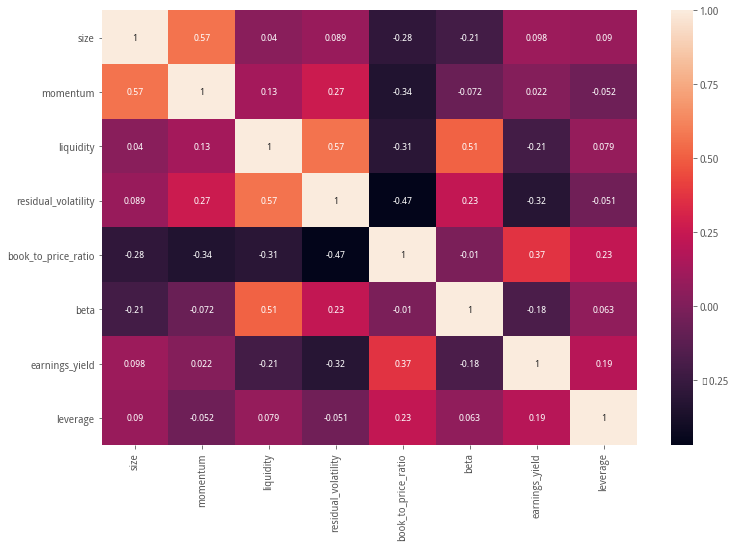

In [36]:
#这里对八个风格因子相关性进行统计展示
factors = ['size','momentum','liquidity','residual_volatility','book_to_price_ratio','beta','earnings_yield','leverage']
factors_ = [f+'_' for f in factors]
import seaborn as sns
df = factor_8_y_dict[list(factor_8_y_dict.keys())[-1]][factors].corr(method='spearman')
fig = plt.figure(figsize= (12,8))
ax = fig.add_subplot(111)
ax = sns.heatmap(df,annot=True,annot_kws={'size':9,'weight':'bold'})

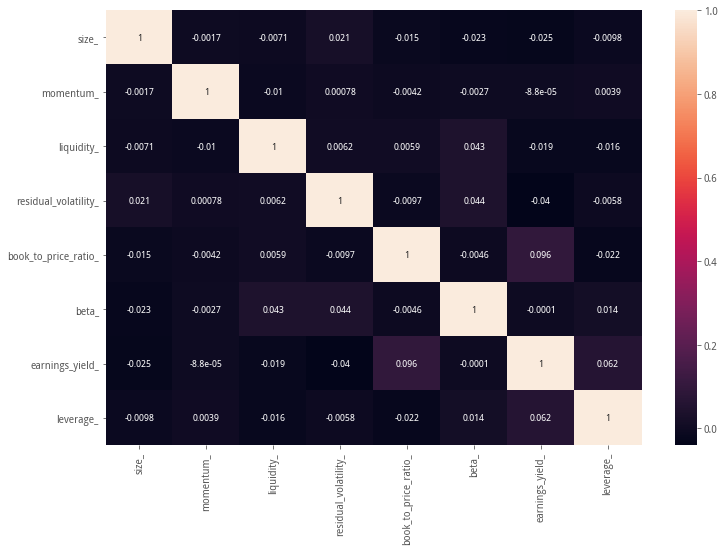

In [38]:
df = factor_8_y_dict[list(factor_8_y_dict.keys())[-1]][factors_].corr(method='spearman')
fig = plt.figure(figsize= (12,8))
ax = fig.add_subplot(111)
ax = sns.heatmap(df,annot=True,annot_kws={'size':9,'weight':'bold'})

正交处理后，因子之间的相关性基本上达到了零

### 结论

本文参考研报中关于选股因子正交的讨论，通过使用正交选股因子来得到更加可控的因子暴露，我们采取研报中给出的参考顺序进行了正交化处理，通过实际组合的构建以及初步回测， 相比于原始因子收益及夏普都有所提升。 在三因子与八因子两种模型中，对因子IC均有提升，在多头组合中也得到了了印证。
